## Import required libraries

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import glob
from tqdm import tqdm

## Parameters

In [ ]:
years_sets = zip(['2020', '2020'],
                 ['1', '2'])
pred_thresh = 0.0

In [ ]:
s3_path = 'S2-RGB-macro-localization-model-deployment'
score_tar_prefix = 'S2-deployment-chip-scores-CHN-10km-pthsh0.002_'

cement_site_geojson = "../../resources/macro-loc-model-build/cement_exact_china_v4.1.geojson"
steel_site_geojson = "../../resources/macro-loc-model-build/steel_exact_china_v4.1.geojson"

macro_10km_shp = "../../resources/nt-model/10km_CS_macro/macroloc_cement_steel_CHN_10.shp"

LOCAL_DIR = '/scratch/'

In [4]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('sfi-shared-assets')

## Prepare Input Files

In [5]:
# Loop over all years and sets
for yr, st in years_sets:

    # Download tar file from S3 and untar
    score_tar_file = score_tar_prefix+yr+'_sg1_mcc5_set'+st+'.tar'
    bucket.download_file(s3_path+'/'+score_tar_file, LOCAL_DIR+score_tar_file)
    !tar -xf {LOCAL_DIR+score_tar_file} -C {LOCAL_DIR}
    print("Finished downloading and extracting ", score_tar_file)

    # Read in GeoJSONs of known cement and steel plants
    cement_site_gdf = gpd.read_file(cement_site_geojson)
    steel_site_gdf = gpd.read_file(steel_site_geojson)

    # Read in shapefile of deployment grid, filter by pred_thresh
    macro_10km_gdf = gpd.read_file(macro_10km_shp)
    macro_10km_gdf = macro_10km_gdf[macro_10km_gdf.preds >= pred_thresh]

    # Get list of GeoJSONS
    score_dir = score_tar_file.replace('.tar', '')
    score_gjsons = glob.glob(LOCAL_DIR+score_dir+'/*.geojson')
    score_gjsons.sort()

    # Loop over all GeoJSONS
    for gf in score_gjsons:

        # Read in DataFrame
        score_gdf = gpd.read_file(gf)

        # Join 10km preds; take max if tile intersects two grid sections
        score_gdf = gpd.sjoin(score_gdf, macro_10km_gdf, how='left', 
                              op='intersects')
        score_gdf = score_gdf.drop(['scene_id', 'index_right', 'length', 
                                    'length_w', 'Count_pnt'], axis=1)
        score_gdf['grpid'] = score_gdf['tile_id']
        score_gdf = score_gdf.sort_values('preds', ascending=False) \
                             .groupby(['grpid']).first()

        # Join to known cement plant sites
        score_gdf = gpd.sjoin(score_gdf, cement_site_gdf, how='left', 
                              op='intersects')
        score_gdf['cement_uid'] = score_gdf.uid
        score_gdf = score_gdf.drop(['index_right', 'uid'], axis=1)

        # Join to known steel plant sites
        score_gdf = gpd.sjoin(score_gdf, steel_site_gdf, how='left', 
                              op='intersects')
        score_gdf['steel_uid'] = score_gdf.uid
        score_gdf = score_gdf.drop(['index_right', 'uid'], axis=1)

        print('Done compiling scores for ', len(score_gdf), ' chips in ', gf)

        # Append to compiled scores file, droping geom column
        if 'compiled_scores_pdf' in locals():
            compiled_scores_pdf = pd.concat([compiled_scores_pdf, 
                                             score_gdf], 
                                            ignore_index=True)
        else:
            compiled_scores_pdf = score_gdf

# Save results in geojson
compiled_scores_pdf.to_file("../../resources/macro-loc-model-deployment/s2_scored_output.geojson", driver='GeoJSON')

# # # Upload to S3 (too bit for git)
# # bucket.upload_file(compiled_scores_csv, s3_path+'/'+compiled_scores_csv.split('/')[-1])

Finished downloading and extracting  S2-deployment-chip-scores-CHN-10km-pthsh0.002_2020_sg1_mcc5_set1.tar
Done compiling scores for  239  chips in  /scratch/S2-deployment-chip-scores-CHN-10km-pthsh0.002_2020_sg1_mcc5_set1/S2-deployment-chip-scores-CHN-10km-pthsh0.002_2020_sg1_mcc5_MGRS-43SEB.geojson
Done compiling scores for  92  chips in  /scratch/S2-deployment-chip-scores-CHN-10km-pthsh0.002_2020_sg1_mcc5_set1/S2-deployment-chip-scores-CHN-10km-pthsh0.002_2020_sg1_mcc5_MGRS-43SEC.geojson
Done compiling scores for  343  chips in  /scratch/S2-deployment-chip-scores-CHN-10km-pthsh0.002_2020_sg1_mcc5_set1/S2-deployment-chip-scores-CHN-10km-pthsh0.002_2020_sg1_mcc5_MGRS-43SED.geojson
Done compiling scores for  624  chips in  /scratch/S2-deployment-chip-scores-CHN-10km-pthsh0.002_2020_sg1_mcc5_set1/S2-deployment-chip-scores-CHN-10km-pthsh0.002_2020_sg1_mcc5_MGRS-43SFA.geojson
Done compiling scores for  67  chips in  /scratch/S2-deployment-chip-scores-CHN-10km-pthsh0.002_2020_sg1_mcc5_set1/

### Compare Probabilities

In [45]:
l8_scores = gpd.read_file("../../resources/macro-loc-model-deployment/scored_output.geojson").drop(['index','prop_rail','prop_water','preds'], axis=1)
s2_scores = gpd.read_file("../../resources/macro-loc-model-deployment/s2_scored_output.geojson").drop(['scene_cloud_pnt', 'scene_group', 'max_cloud_cover', 'index','prop_rail','prop_water','preds'], axis=1)

In [46]:
# known cement plants
l8_cement = l8_scores[l8_scores.cement_uid.notnull()]
s2_cement = s2_scores[s2_scores.cement_uid.notnull()]

In [48]:
len(l8_cement), len(s2_cement)

(675, 612)

In [47]:
# known steel plants
l8_steel = l8_scores[l8_scores.steel_uid.notnull()]
s2_steel = s2_scores[s2_scores.steel_uid.notnull()]

In [49]:
len(l8_steel), len(s2_steel)

(129, 91)

In [53]:
cement_gdf = gpd.sjoin(s2_cement, l8_cement, how='left', op='intersects')

In [63]:
cement_agg_gdf = cement_gdf.groupby(['tile_id_left','year_left','cement_prob_left','cement_uid_left']).agg({'cement_prob_right':'mean'}).reset_index()

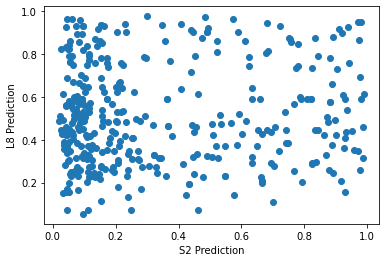

In [69]:
plt.scatter(cement_agg_gdf.cement_prob_left.values, cement_agg_gdf.cement_prob_right.values)
plt.xlabel('S2 Prediction')
plt.ylabel('L8 Prediction')
plt.show()

In [55]:
steel_gdf = gpd.sjoin(s2_steel, l8_steel, how='left', op='intersects')

In [64]:
steel_agg_gdf = steel_gdf.groupby(['tile_id_left','year_left','steel_prob_left','steel_uid_left']).agg({'steel_prob_right':'mean'}).reset_index()

In [67]:
steel_agg_gdf

,tile_id_left,year_left,steel_prob_left,steel_uid_left,steel_prob_right
0,MGRS-45TWJ-0338,2020,0.092780,CHN0014,0.524710
1,MGRS-47RQK-0384,2020,0.872235,CHN0075,0.749981
2,MGRS-47RRH-0321,2020,0.794473,CHN0072,0.691097
3,MGRS-47RRH-0393,2020,0.117894,CHN0071,0.868268
4,MGRS-47RRH-0468,2020,0.889687,CHN0187,0.647188
...,...,...,...,...,...
86,MGRS-51TVF-0538,2020,0.642454,CHN0007,0.906509
87,MGRS-51TVF-1055,2020,0.968887,CHN0008,0.850990
88,MGRS-51TYH-0094,2020,0.408641,CHN0013,0.590758
89,MGRS-52TET-0264,2020,0.632331,CHN0028,NaN


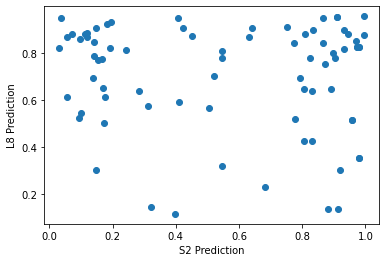

In [68]:
plt.scatter(steel_agg_gdf.steel_prob_left.values, steel_agg_gdf.steel_prob_right.values)
plt.xlabel('S2 Prediction')
plt.ylabel('L8 Prediction')
plt.show()